# Visual Attention Through Uncertainty Minimization in Recurrent Generative Models 

This notebook recreats the plots depicted in the paper "Visual Attention Through Uncertainty Minimization in Recurrent Generative Models"

# Settings

## Imports

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import math
import scipy
from scipy.stats import gamma, uniform

import sys
import subprocess
from pathlib import Path
import pickle as pkl

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sn
from IPython.display import IFrame
from IPython.core.display import Image, display
from wand.image import Image as wimage
%matplotlib inline

from src.data_loader import mnist_data, get_data_loader
from src.utils import *
from src.trainer import Trainer
from src.config import cfg_from_file, cfg_from_list, cfg_set_log_file

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

## Plotting

In [2]:
from matplotlib import rcParams
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Palatino"]
rcParams["font.size"] = 20

PLOT_COLOR = (0.04,.34,.57)

# Data

In [3]:
data_dir = Path('data/')
small_data = data_dir / 'mnist.t7'
trans_data = data_dir / 'mnist_trans.t7'
clut_data = data_dir / 'mnist_cluttered.t7'

## Configuration Files
The configuration files specify the model parameters for each experiment. Change files to test different parameter settings

In [4]:
conf_dir = Path('configs/')
conf_unsup = cfg_from_file(conf_dir / 'small_unsupervised.yaml')
conf_sup  = cfg_from_file(conf_dir / 'small_supervised.yaml' )
conf_bin3 =  cfg_from_file(conf_dir / 'bin3.yaml')
conf_bin6 =  cfg_from_file(conf_dir / 'bin6.yaml')
conf_trans = cfg_from_file(conf_dir / 'trans.yaml')
conf_clut = cfg_from_file(conf_dir / 'cluttered.yaml')

plot_dir = Path('plots/')

## Dataloader
Create data loaders for the three different datasets used in the article - classical MNIST, translated MNIST, and cluttered MNIST. Since running the models on the test sets is computationally expensive use GPU acceleration if possible


In [5]:
gpu = True
if gpu:
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=0
    conf_unsup.GPU = gpu
    conf_trans.GPU = gpu
    conf_clut.GPU = gpu

small_loader = get_data_loader(
    small_data,
    conf_unsup.TRAIN.BATCH_SIZE,
    conf_unsup.SEED,
    conf_unsup.TRAIN.NUM,
    conf_unsup.TRAIN.VAL_NUM,
    conf_unsup.TRAIN.IS_TRAIN,
    conf_unsup.TRAIN.NUM_WORKERS,
    conf_unsup.GPU,
    conf_unsup.TRAIN.FRAC_LABELS,
)

trans_loader = get_data_loader(
    trans_data,
    conf_trans.TRAIN.BATCH_SIZE,
    conf_trans.SEED,
    conf_trans.TRAIN.NUM,
    conf_trans.TRAIN.VAL_NUM,
    conf_trans.TRAIN.IS_TRAIN,
    conf_trans.TRAIN.NUM_WORKERS,
    conf_trans.GPU,
    conf_trans.TRAIN.FRAC_LABELS,
    data_size=70000,
)

clut_loader = get_data_loader(
    clut_data,
    conf_clut.TRAIN.BATCH_SIZE,
    conf_clut.SEED,
    conf_clut.TRAIN.NUM,
    conf_clut.TRAIN.VAL_NUM,
    conf_clut.TRAIN.IS_TRAIN,
    conf_clut.TRAIN.NUM_WORKERS,
    conf_clut.GPU,
    conf_clut.TRAIN.FRAC_LABELS,
    data_size=70000,
)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Trainer
Trainer objects load pretrained model weights and specify the training and testing procedures.

In [6]:
unsup_trainer = Trainer(small_loader, conf_unsup)
sup_trainer = Trainer(small_loader, conf_sup)
bin3_trainer = Trainer(small_loader, conf_bin3)
bin6_trainer = Trainer(small_loader, conf_bin6)
trans_trainer = Trainer(trans_loader, conf_trans)
clut_trainer = Trainer(clut_loader, conf_clut)

# Test models
Run the models on the test data to reproduce statistics and figures from the article

In [7]:
%%capture
np.random.seed(conf_unsup.SEED)
torch.manual_seed(conf_unsup.SEED)
torch.cuda.manual_seed(conf_unsup.SEED)

test_all = False
if test_all:
    unsup_trainer.test();
    sup_trainer.test();
    bin3_trainer.test();
    bin6_trainer.test();
    trans_trainer.test();
    clut_trainer.test();

## Plotting
Example trajectories, heatmaps, and prediction error and uncertainty statistics

|<img src="plots/unsup/000002.png" alt="Drawing" style="width: 300px;"/>|<img src="plots/sup/000002.png" alt="Drawing" style="width: 300px;"/>|
|:-:|:--:|
| *Unsupervised* | *Supervised* |

*Unsupervised*

|<img src="plots/unsup/heatmap_bef0.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef1.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef2.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef3.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef4.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef5.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef6.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef7.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef8.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_bef9.png" alt="Drawing" style="width: 75px;"/>|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|<img src="plots/unsup/heatmap_aft0.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft1.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft2.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft3.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft4.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft5.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft6.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft7.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft8.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/unsup/heatmap_aft9.png" alt="Drawing" style="width: 75px;"/>|
| *0* | *1* | *2* | *3* | *4* | *5* | *6* | *7* | *8* | *9* |

---

*Supervised*

|<img src="plots/sup/heatmap_bef0.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef1.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef2.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef3.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef4.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef5.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef6.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef7.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef8.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_bef9.png" alt="Drawing" style="width: 75px;"/>|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
|<img src="plots/sup/heatmap_aft0.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft1.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft2.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft3.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft4.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft5.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft6.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft7.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft8.png" alt="Drawing" style="width: 75px;"/>|<img src="plots/sup/heatmap_aft9.png" alt="Drawing" style="width: 75px;"/>|
| *0* | *1* | *2* | *3* | *4* | *5* | *6* | *7* | *8* | *9* |

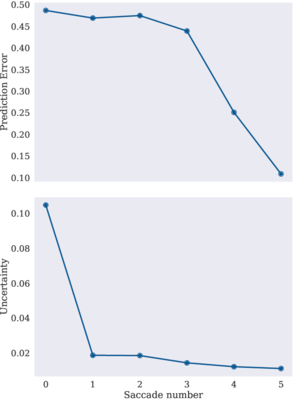

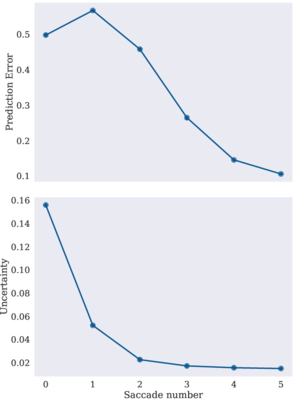

In [8]:
x = wimage(filename= plot_dir / 'unsup/comb_var_err.pdf')
x.transform(resize='x400')
y = wimage(filename= plot_dir / 'sup/comb_var_err.pdf')
y.transform(resize='x400')
display(x,y)

# Pixel Classifier

In [ ]:
num = 10000
N = 100000
data = mnist_data('../mnist_small.t7', torch.arange(N-num,N))
scaler = StandardScaler()
x_data = data.labeled
x_norm = scaler.fit_transform(x_data.view(num,-1))
y_data = data.labels.argmax(-1)

In [ ]:
clf = LogisticRegression(C=50. / num,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1).fit(x_norm,y_data)
clf.score(x_norm,y_data)


In [ ]:
x_norm = torch.tensor(x_norm).view(num,30,30)

In [ ]:
size = 8
off = size // 2
pad_dims = (
        off + 1,
        off + 1,
        off + 1,
        off + 1,
    )
x_pad = F.pad(x_norm, pad_dims, "constant", 0)

In [ ]:
scores = torch.zeros(30,30)
for i in range(30):
    for j in range(30):
        
        from_x, to_x = i+1,i+2*off+1
        from_y, to_y = j+1,j+2*off+1
        
        d1 = torch.zeros_like(x_pad)
        d1[:,from_y:to_y,from_x:to_x] = x_pad[:,from_y:to_y,from_x:to_x]
        inp = d1[:,off+1:-(off+1),off+1:-(off+1)]

        score = clf.score(inp.contiguous().view(num,-1),y_data)
        scores[j,i] = score
         

In [ ]:
for i in range(30):
    for j in range(30):
        
        from_to_x = torch.arange(i-off,i+off) + off + 1
        from_to_y = torch.arange(j-off,j+off) + off + 1
    
        d1 = d[:,from_to_y,from_to_x].view(num,-1)
        loc[:,0] = (i / 30) * 2 - 1
        loc[:,1] = (i / 30) * 2 - 1
        features = torch.cat((d1,loc),-1)
        score = clf.score(features,y)
        scores[j,i] = score
        p = sum(clf.predict(features))
        if p:
            print(p)

# Distances

In [ ]:
all_dists = dists.flatten()

x = np.linspace(0,30,100)
param = gamma.fit(all_dists)
pdf_fitted = gamma.pdf(x, *param)
print(param)

samples_gamma = gamma.rvs(*param,1000)
samples_uniform = uniform.rvs(4,10,100)

samples = np.concatenate([samples_gamma,samples_uniform])

In [ ]:
sn.set(font="serif",font_scale=2,context='paper', style='dark', rc={"lines.linewidth": 2.5})
x = np.linspace(0,30,100)
f = plt.figure(figsize=(12,9))
plt.hist(all_dists,bins=range(30), ec='white', density=True, alpha=.6, label='Saccades')
plt.plot(x,pdf_fitted,label='Gamma')
plt.ylabel('Probability Density')
plt.xlabel('Amplitude')
plt.legend()
f.savefig('saccade_dist.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
x = np.linspace(0,30,30)
f, ax1 = plt.subplots(1,1,figsize=(12,9))
ax1.hist(all_dists,bins=x, color=sn.color_palette()[0],ec='white', density=True, alpha=.6, label='Predict')
ax2 = ax1.twinx().twiny()
x = np.linspace(0,60,30)
ax2.hist(dists_search.flatten(),bins=x, color=sn.color_palette()[1],ec='white', density=True, alpha=.6, label='Search')
plt.ylabel('Probability Density')
plt.xlabel('Amplitude')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
#f.savefig('saccade_dist.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
f = plt.figure(figsize=(12,9))
for c,i in enumerate([0,4]):
    plt.hist(dists[:,i],bins=range(30),ec='white',density=True, fill=True, alpha=.6, label=f'saccade {i+1}')
plt.ylabel('Probability Density')
plt.xlabel('Amplitude')
plt.legend()    
f.savefig('amp_dist_first_last.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

# Variances

In [ ]:
var_max = var_dist.view(*var_dist.shape[:2],-1).max(-1)[0]
var_max_search = var_search.view(*var_search.shape[:2],-1).max(-1)[0]
var_sum = var_dist.view(*var_dist.shape[:2],-1).sum(-1)
var_mean = var_dist.view(*var_dist.shape[:2],-1).mean(-1)
print(var_dist.shape)
print(var_max.shape)

In [ ]:
f = plt.figure(figsize=(12,9))
for c,i in enumerate([0,4]):
    plt.hist(var_max[:,i],bins=20,ec='white',density=True, fill=True, alpha=.8, label=f'saccade {i+1}')
plt.ylabel('Probability Density')
plt.xlabel('Uncertainty')
plt.xlim([0,0.22])
plt.legend()    
# f.savefig('var_dist_first_last.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
var_max_norm = (var_max/var_max.max()) * 1200

f = plt.figure(figsize=(12,9))

x = np.linspace(0,var_max_norm.max(),50)
digitized = np.digitize(var_max_norm[:,:-1].flatten(), x) 
y_data = torch.tensor([dists.flatten()[digitized == i].mean() for i in range(len(x))])
plt.scatter(x[:25],y_data[:25],label='saccades',s=50)
plt.ylabel('Saccade Amplitude')
plt.xlabel('Uncertainty')


a = 120; b = 30;
c = 18; d = 7.07;
y_func = lambda x,a,b,c,d: b*np.exp(-a/(x))-((x-c)>0)*(b*np.exp(-a/(x-c))) + d
# y_func = lambda x,a,b,c,d: b*np.exp(-a/(x+c))-(b*np.exp(-a/(x))) + d
low = [0,0,0,0]
high = 150
popt, pcov = scipy.optimize.curve_fit(y_func,x,y_data.numpy()[:],p0=[a,b,c,d], bounds=(low,high))
print(popt)

a,b,c,d = popt
plt.plot(x[:25],y_func(x,a,b,c,d)[:25],c=sn.color_palette()[1],label='fit')
plt.legend()
# f.savefig('amp_unc.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

# Search

In [ ]:
f = plt.figure(figsize=(12,9))
for c,i in enumerate([4,0]):
    plt.hist(var_max_search[:,i],bins=np.linspace(0,var_max_search[:,i].max(),30),ec='white',density=True, fill=True, alpha=.8, label=f'saccade {i+1}')
plt.ylabel('Probability Density')
plt.xlabel('Uncertainty')
plt.xlim([0,2e-3])
plt.ylim([0,15000])
plt.ticklabel_format(style='sci', axis='both',useOffset=False,scilimits=(-1,1))
plt.legend()    
f.savefig('var_dist_first_last_search.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
var_max_search_norm = (var_max_search/var_max_search.max()) * 1200

f = plt.figure(figsize=(12,9))

x = np.linspace(0,var_max_search_norm.max(),50)
digitized = np.digitize(var_max_search_norm[:,:-1].flatten(), x) 
y_data = torch.tensor([dists.flatten()[digitized == i].mean() for i in range(len(x))])
plt.scatter(x[:25],y_data[:25],label='saccades',s=50)
plt.ylabel('Saccade Amplitude')
plt.xlabel('Uncertainty')

a = 120; b = 30;
c = 18; d = 22.5;
popt, pcov = scipy.optimize.curve_fit(y_func,x,y_data.numpy()[:],p0=[a,b,c,d], bounds=(low,high))
print(popt)

a,b,c,d = popt
plt.plot(x[:25],y_func(x,a,b,c,d)[:25],c=sn.color_palette()[1],label='fit')
plt.legend()
# f.savefig('amp_unc_search.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

# Difference Classification

In [ ]:
var_dist_class = pkl.load(open('class/var_dist.pkl','rb'))
labels = pkl.load(open('class/labels.pkl','rb'))
conf_matrix = pkl.load(open('class/conf_matrix.pkl','rb'))
var_class_max = var_dist_class.view(*var_dist_class.shape[:2],-1).max(-1)[0]
locs = pkl.load(open('no_class/locs.pkl','rb'))
clocs = pkl.load(open('class/locs.pkl','rb'))

In [ ]:
cmap = plt.get_cmap("gist_heat")
f, ax = plt.subplots(3,1, figsize=(15,15))
plt.rc('font', size=12)

no_class = var_dist[:,:1,...].contiguous().view(-1,30,30).mean(0)
no_class/=no_class.sum()
ax[0].imshow(no_class, cmap=cmap)
ax[0].axis('off')
#ax[0].set_title('No Classification')

classi = var_dist_class[:,:1,...].contiguous().view(-1,30,30).mean(0)
classi/=classi.sum()
ax[1].imshow(classi, cmap=cmap)
ax[1].axis('off')
#ax[1].set_title('Classification')

im = ax[2].imshow(scores/scores.sum(), cmap=cmap)
ax[2].axis('off')
#ax[2].set_title('Logistic Regression')

#mean_mean = x_data.squeeze().mean(0)#mean.squeeze().max(0)[0]
#ax[3].imshow(mean_mean,cmap=cmap)
# ax[3].axis('off')
# ax[3].set_title('Mean digit')



f.tight_layout()
f.savefig('diff_class_log.pdf', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
cmap = plt.get_cmap("gist_heat")
fig, ax = plt.subplots(3,2, figsize=(4,6))
for idx,i in enumerate([3,6,9]):
    c = var_dist[labels==i,4:-1,...].contiguous().view(-1,30,30).mean(0)
    c/=c.max()
    cc = var_dist_class[labels==i,4:-1,...].contiguous().view(-1,30,30).mean(0)
    cc/=cc.max()
    ax[idx,0].imshow(c, cmap=cmap)
    ax[idx,0].axis('off')
    ax[idx,1].imshow(cc, cmap=cmap)
    ax[idx,1].axis('off')

plt.subplots_adjust(wspace=.01, hspace=.1)
#fig.tight_layout()
fig.savefig('var_diff.pdf', bbox_inches="tight", pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(10, 7))
df_cm = pd.DataFrame(conf, range(conf.shape[0]), range(conf.shape[1]))
sn.set(font_scale=1.1)  # for label size
ax = sn.heatmap(
    df_cm, annot=True, annot_kws={"size": 16}, cmap="OrRd", fmt=".2g",vmin=0.8, vmax=1
)  
ax.set(xlabel=' ', ylabel=' ')
fig.savefig('pred_corr.pdf', bbox_inches="tight", pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(10, 7))
df_cm = pd.DataFrame(cconf, range(conf.shape[0]), range(conf.shape[1]))
sn.set(font_scale=1.1)  # for label size
ax = sn.heatmap(
    df_cm, annot=True, annot_kws={"size": 16}, cmap="OrRd", fmt=".2g",vmin=0.8, vmax=1
)  
ax.set(xlabel=' ', ylabel=' ')
fig.savefig('class_corr.pdf', bbox_inches="tight", pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(10, 7))
df_cm = pd.DataFrame(conf_matrix.numpy(), range(conf.shape[0]), range(conf.shape[1]))
sn.set(font_scale=1.1)  # for label size
ax = sn.heatmap(
    df_cm, annot=True, annot_kws={"size": 16}, cmap="OrRd", fmt="g",vmin=0, vmax=20,cbar_kws={'format': '%.1f'}
)  
ax.set(xlabel='Predicted', ylabel='True')
fig.savefig('conf_matrix.pdf', bbox_inches="tight", pad_inches=0)

In [ ]:
i = 0
f = plt.figure()
plt.hist(var_max[:,i],bins=30, ec=plt.cm.Pastel1(0),density=True, fill=True,color=plt.cm.Pastel1(0), alpha=.6, label=f'var 0')
plt.hist(var_class_max[:,i],bins=30, ec=plt.cm.Pastel1(1),density=True, fill=True,color=plt.cm.Pastel1(1), alpha=.6, label=f'var 1')
plt.ylabel('Probability Density')
plt.xlabel('Amplitude')
plt.legend()   

# Prediction Error

In [ ]:
mean_err = err_dist.view(10000,6,-1).mean(-1)
mean_var = var_dist.view(10000,6,-1).mean(-1)

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(err_dist.flatten(),var_dist.flatten())

In [ ]:
r_value, p_value

In [ ]:
sn.set(font="serif",font_scale=2,context='paper', style='dark', rc={"lines.linewidth": 2.5})
errs = err_dist.view(10000,6,-1)  #/ 5
vars = var_dist.view(10000,6,-1)

y_err = errs.mean(-1).mean(0).numpy()
y_var = vars.max(-1)[0].mean(0).numpy()
f, ax = plt.subplots(2,1, sharex=True, figsize=(9,12))
ax[0].plot(np.arange(6),y_err,marker='o',markersize=10)
ax[0].set_ylim(0.,0.6)
ax[0].set_ylabel('Prediction Error')
ax[1].errorbar(np.arange(6),y_var,marker='o',markersize=10)
ax[1].set_xlabel('Saccade number')
ax[1].set_ylabel('Uncertainty')
#ax[1].set_yticklabels(['  0','  1','  2','  3','  4','  5'])
f.tight_layout()
f.savefig('err_unc.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
sn.set(font="serif",font_scale=2,context='paper', style='dark', rc={"lines.linewidth": 2.5})
errs = err_class.view(10000,6,-1)  #/ 5
vars = var_class.view(10000,6,-1)

y_err = errs.mean(-1).mean(0).numpy()
y_var = vars.max(-1)[0].mean(0).numpy()
f, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(np.arange(6),y_err,marker='o',markersize=10)
ax[0].set_ylim(0.,0.6)
ax[0].set_xlabel('Saccade number')
ax[0].set_ylabel('Prediction Error')
ax[1].errorbar(np.arange(6),y_var,marker='o',markersize=10)
ax[1].set_xlabel('Saccade number')
ax[1].set_ylabel('Uncertainty')
#ax[1].set_yticklabels(['  0','  1','  2','  3','  4','  5'])
f.tight_layout()
f.savefig('err_unc_class.pdf', bbox_inches = 'tight', pad_inches = 0, dpi=600)

In [ ]:
sn.set()
fig, ax = plt.subplots(2, 5, subplot_kw=dict(projection='polar'), figsize=(15,7))
fig.suptitle('Classification\n')
for i,ang in enumerate(angles):
    if i < 5:
        rose_plot(ax[0,i%5], ang, density=False, offset=0)
        ax[0,i%5].set_title(f'{i}\n')
    else:
        rose_plot(ax[1,i%5], ang, density=False, offset=0)
        ax[1,i%5].set_title(f'{i}\n')
fig.tight_layout()    
fig.savefig('roses_class.pdf')